# Cellshapy


In [359]:
%matplotlib inline
import matplotlib.pylab as plt
import os, sys, glob
from IPython.display import HTML
%load_ext autoreload
%autoreload 2
import cellshapy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [360]:
#data_folder = '/Users/wdeback/Work/celldynamics/data_simulated/SweepNPF_inh_52/**'
data_folder = '../data/SweepNPF_inh_52/**'

#data_folder = '/home/debacwa/Simulation/Example-Protrusion_sweep_2/**'
tifstack_fn = '*.tif' 

#data_folder = '/Users/wdeback/Work/celldynamics/data_simulated/'
#tifstack_fn = 'morphing*.tif' 

In [361]:
from skimage.external import tifffile
import numpy as np
fns = glob.glob(os.path.join(data_folder, tifstack_fn))
ims = np.array([tifffile.imread(fn) for fn in fns])

os.path.join(data_folder, tifstack_fn)

/home/debacwa/miniconda3/envs/cellshapy/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


'../data/SweepNPF_inh_52/**/*.tif'

In [362]:
def animate(ims, duration=5.0):
    
    import matplotlib.animation as animation

    offset = 5
    n_videos = len(ims)
    n_frames = len(ims[offset:])
    nr = int(np.ceil(np.sqrt(n_videos)))
    nc = nr

    fig, ax = plt.subplots(nr, nc, figsize=(15,15), squeeze=False, sharex=True, sharey=True)
    ax = ax.flatten()
    
    plots = []
    for i, im in enumerate(ims): plots.append( ax[i].imshow(im[offset], cmap='gray_r', animated=True))
    for a in ax: a.axis('off')
    for a in ax[i:]: a.set_visible(False)
        
    def update(t):
        print('.', end='')
        for i, im in enumerate(ims): 
            plots[i].set_array(im[t+offset])
        return plots

    anim = animation.FuncAnimation(fig,
                               update,
                               frames=n_frames,
                               interval=((duration*1000.)/n_frames),
                               blit=True)

    
    return anim

In [363]:
#anim = animate(ims, duration=5.0)
#HTML(anim.to_html5_video())

## Load videos from tiff files

In [364]:
paths = os.path.join(data_folder, tifstack_fn)

In [365]:
paths

'../data/SweepNPF_inh_52/**/*.tif'

In [366]:
videos = cellshapy.VideoCollection.from_glob(paths, composite=True)

Creating VideoCollection from glob expression ../data/SweepNPF_inh_52/**/*.tif: 40 video files or directories
Creating VideoCollection from list of paths. 40 video files or directories


Iteration 3, error: 0.000080, time: 9.07 sec
4040 contours aligned in 12.28 sec


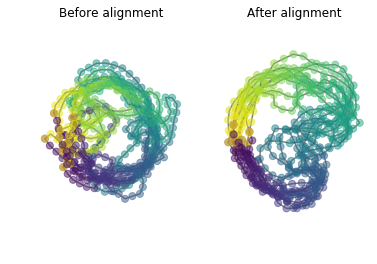

In [367]:
_ = videos.align_contours(show_samples=10)

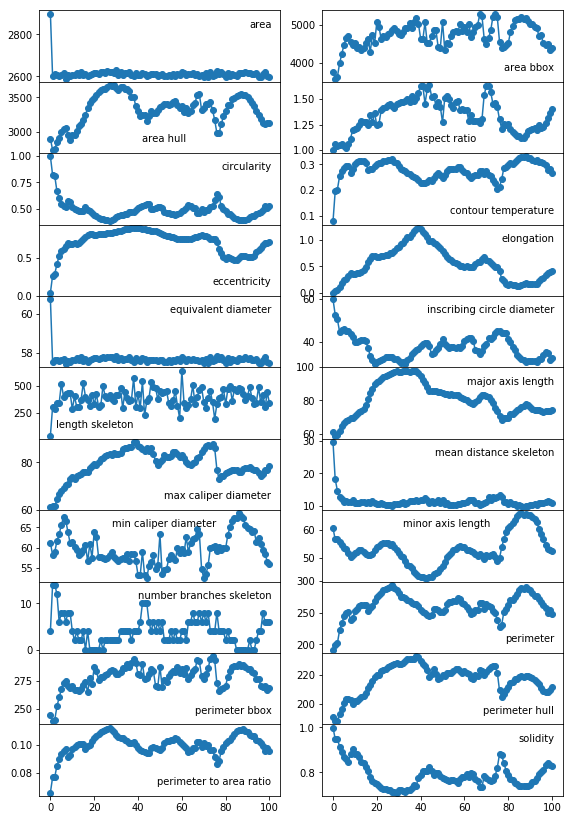

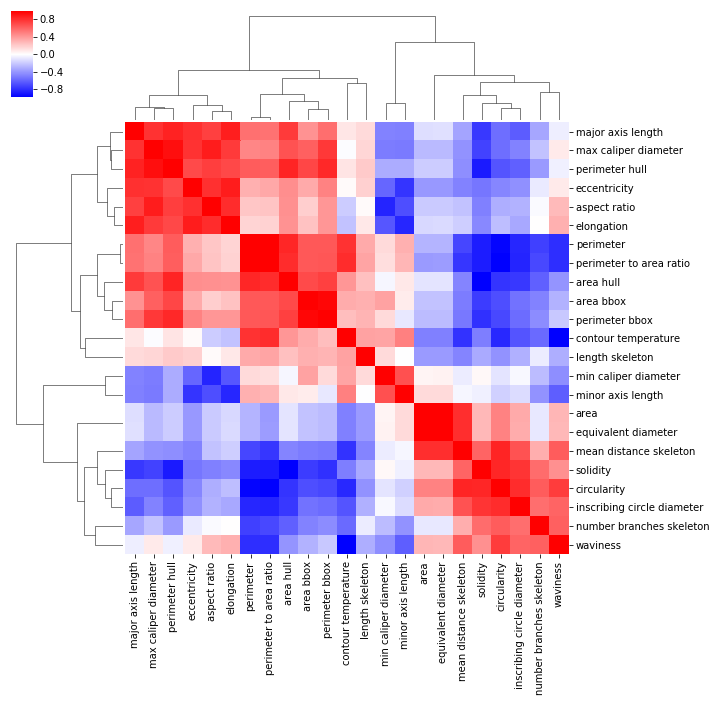

In [400]:
#help(videos[0])
_ = videos[1].plot_timeseries_features()

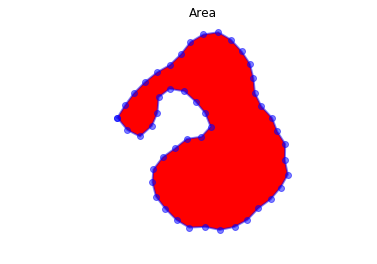

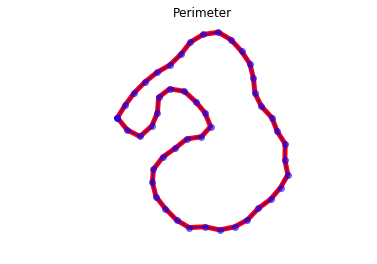

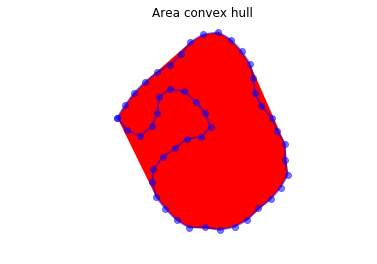

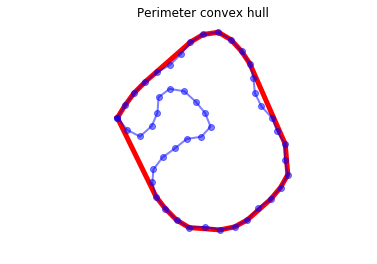

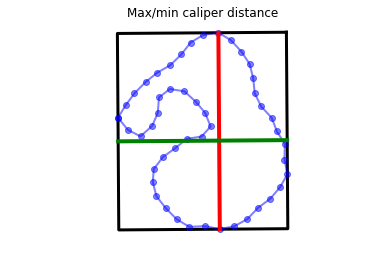

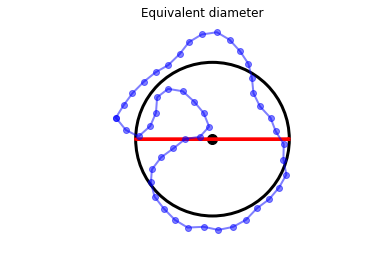

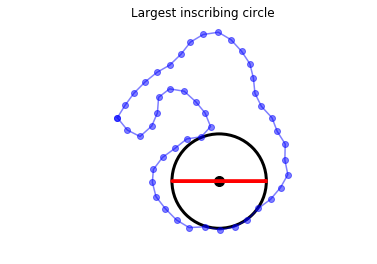

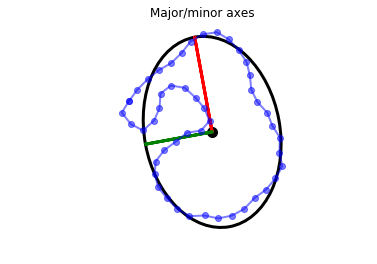

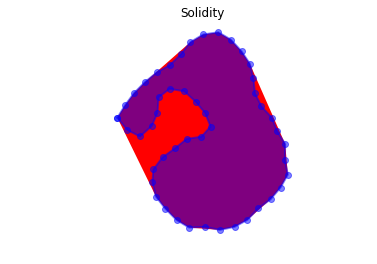

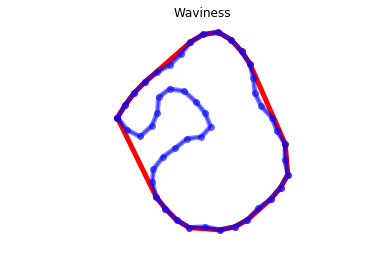

{'area': 2609.9429185922904,
 'perimeter': 270.7329669539147,
 'perimeter to area ratio': 0.10373137474590377,
 'area hull': 3170.131304221942,
 'perimeter hull': 208.30719077380743,
 'solidity': 0.8232917403504392,
 'waviness': 0.769419377024987,
 'area bbox': 4732.626834256503,
 'perimeter bbox': 275.9556855943574,
 'max caliper diameter': 74.17008357364605,
 'min caliper diameter': 63.80775922353267,
 'aspect ratio': 1.16239912631647,
 'equivalent diameter': 57.64618403201733,
 'circularity': 0.44746450188057735,
 'inscribing circle diameter': 35.41704416449634,
 'major axis length': 76.75549988807018,
 'minor axis length': 54.0198228084551,
 'eccentricity': 0.710407179439831,
 'elongation': 0.42087653155315397,
 'length skeleton': 354.0,
 'number branches skeleton': 2,
 'mean distance skeleton': 10.694514318372653,
 'contour temperature': 0.32085652863760494}

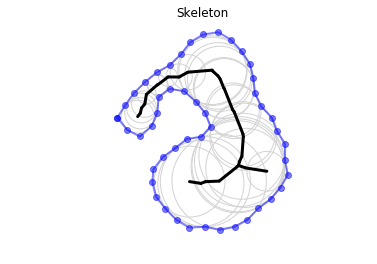

In [401]:
from cellshapy.utils.contours import extract_features
videos[0][45].extract_features(plot=True, extract_skeleton=True)


In [13]:
#animation = videos[2].show(duration=8.0, show_image=True, show_contour=False)
#HTML(animation.to_html5_video())

In [14]:
#animation = videos[2].show(duration=8.0, show_image=False)
#HTML(animation.to_html5_video())

In [15]:
#animation = videos.show(duration=8.0, show_image=True, show_contour=False)
#HTML(animation)

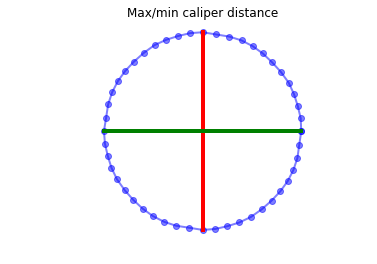

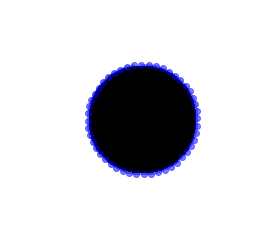

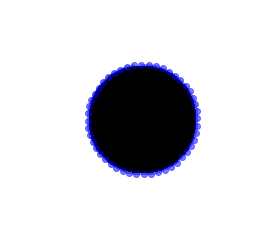

In [56]:
from skimage.draw import ellipse
img = np.zeros((200,200), dtype=np.uint8)
rr, cc = ellipse(100,100,50,50, shape=None, rotation=0.2*np.pi)
img[rr, cc] = 255

f = cellshapy.Frame(image=img)
f.show(show_image=True, show_contour=True)

In [57]:
def _det(xvert, yvert):
    '''Compute twice the area of the triangle defined by points with using
    determinant formula.
    https://code.activestate.com/recipes/578381-a-point-in-polygon-program-sw-sloan-algorithm/

    Input parameters:

    xvert -- A vector of nodal x-coords (array-like).
    yvert -- A vector of nodal y-coords (array-like).

    Output parameters:

    Twice the area of the triangle defined by the points.

    Notes:

    _det is positive if points define polygon in anticlockwise order.
    _det is negative if points define polygon in clockwise order.
    _det is zero if at least two of the points are concident or if
        all points are collinear.

    '''
    xvert = np.asfarray(xvert)
    yvert = np.asfarray(yvert)
    x_prev = np.concatenate(([xvert[-1]], xvert[:-1]))
    y_prev = np.concatenate(([yvert[-1]], yvert[:-1]))
    return np.sum(yvert * x_prev - xvert * y_prev, axis=0)

def is_inside(xpoint, ypoint, contour, smalld=1e-12):
    '''Check if point is inside a general polygon.
    https://code.activestate.com/recipes/578381-a-point-in-polygon-program-sw-sloan-algorithm/

    Input parameters:

    xpoint -- The x-coord of the point to be tested.
    ypoint -- The y-coords of the point to be tested.
    smalld -- A small float number.

    xpoint and ypoint could be scalars or array-like sequences.

    Output parameters:

    mindst -- The distance from the point to the nearest point of the
              polygon.
              If mindst < 0 then point is outside the polygon.
              If mindst = 0 then point in on a side of the polygon.
              If mindst > 0 then point is inside the polygon.

    Notes:

    An improved version of the algorithm of Nordbeck and Rydstedt.

    REF: SLOAN, S.W. (1985): A point-in-polygon program. Adv. Eng.
         Software, Vol 7, No. 1, pp 45-47.

    '''
    
    import numpy as np
    from cellshapy.utils.contours import close_contour, _make_anticlockwise
    
    contour = close_contour(contour)
    contour = _make_anticlockwise(contour)
    x = contour[:,0]
    y = contour[:,1]

    
    xpoint = np.asfarray(xpoint)
    ypoint = np.asfarray(ypoint)
    # Scalar to array
    if xpoint.shape is tuple():
        xpoint = np.array([xpoint], dtype=float)
        ypoint = np.array([ypoint], dtype=float)
        scalar = True
    else:
        scalar = False
    # Check consistency
    if xpoint.shape != ypoint.shape:
        raise IndexError('x and y has different shapes')
    # If snear = True: Dist to nearest side < nearest vertex
    # If snear = False: Dist to nearest vertex < nearest side
    snear = np.ma.masked_all(xpoint.shape, dtype=bool)
    # Initialize arrays
    mindst = np.ones_like(xpoint, dtype=float) * np.inf
    j = np.ma.masked_all(xpoint.shape, dtype=int)
    n = len(x) - 1  # Number of sides/vertices defining the polygon
    # Loop over each side defining polygon
    for i in range(n):
        d = np.ones_like(xpoint, dtype=float) * np.inf
        # Start of side has coords (x1, y1)
        # End of side has coords (x2, y2)
        # Point has coords (xpoint, ypoint)
        x1 = x[i]
        y1 = y[i]
        x21 = x[i + 1] - x1
        y21 = y[i + 1] - y1
        x1p = x1 - xpoint
        y1p = y1 - ypoint
        # Points on infinite line defined by
        #     x = x1 + t * (x1 - x2)
        #     y = y1 + t * (y1 - y2)
        # where
        #     t = 0    at (x1, y1)
        #     t = 1    at (x2, y2)
        # Find where normal passing through (xpoint, ypoint) intersects
        # infinite line
        t = -(x1p * x21 + y1p * y21) / (x21 ** 2 + y21 ** 2)
        tlt0 = t < 0
        tle1 = (0 <= t) & (t <= 1)
        # Normal intersects side
        d[tle1] = ((x1p[tle1] + t[tle1] * x21) ** 2 +
                   (y1p[tle1] + t[tle1] * y21) ** 2)
        # Normal does not intersects side
        # Point is closest to vertex (x1, y1)
        # Compute square of distance to this vertex
        d[tlt0] = x1p[tlt0] ** 2 + y1p[tlt0] ** 2
        # Store distances
        mask = d < mindst
        mindst[mask] = d[mask]
        j[mask] = i
        # Point is closer to (x1, y1) than any other vertex or side
        snear[mask & tlt0] = False
        # Point is closer to this side than to any other side or vertex
        snear[mask & tle1] = True
    if np.ma.count(snear) != snear.size:
        raise IndexError('Error computing distances')
    mindst **= 0.5
    # Point is closer to its nearest vertex than its nearest side, check if
    # nearest vertex is concave.
    # If the nearest vertex is concave then point is inside the polygon,
    # else the point is outside the polygon.
    jo = j.copy()
    jo[j == 0] -= 1
    area = _det([x[j + 1], x[j], x[jo - 1]], [y[j + 1], y[j], y[jo - 1]])
    mindst[~snear] = np.copysign(mindst, area)[~snear]
    # Point is closer to its nearest side than to its nearest vertex, check
    # if point is to left or right of this side.
    # If point is to left of side it is inside polygon, else point is
    # outside polygon.
    area = _det([x[j], x[j + 1], xpoint], [y[j], y[j + 1], ypoint])
    mindst[snear] = np.copysign(mindst, area)[snear]
    # Point is on side of polygon
    mindst[np.fabs(mindst) < smalld] = 0
    # If input values were scalar then the output should be too
    if scalar:
        mindst = float(mindst)
    return mindst

(45, 2)
(45, 2, 2)
(90, 2)
(46, 2)
[[-31.19871281   8.02137795]
 [-28.51019855   8.26482965]
 [-28.09953023   5.75973857]
 [-27.53452684   9.5218717 ]
 [-27.07833998  11.47943221]
 [-25.84064397  12.96085735]
 [-25.22774449  16.60914421]
 [-21.14666066  20.16922078]
 [-20.98848806  20.17936336]
 [-17.09942722  23.14719804]
 [-13.80620752 -14.68768861]
 [-12.97814691  23.10732523]
 [-10.3887091  -16.072367  ]
 [ -9.80632097 -16.16874284]
 [ -9.70157017  24.91494666]
 [ -9.05281039 -16.12809661]
 [ -6.61329488 -23.69386486]
 [ -5.76154879 -10.13035048]
 [ -5.19191402 -17.69982169]
 [ -4.78534449 -16.80749048]
 [ -3.10749247 -16.15583086]
 [ -0.60171367  28.07933994]
 [ -0.59821845  26.28951865]
 [ -0.57052226  25.68557245]
 [ -0.52239929  26.71162141]
 [ -0.26538755  25.24863247]
 [  0.0675467   31.64037634]
 [  1.62946998  23.52718312]
 [  2.06193561 -15.93526826]
 [  2.21525106 -16.3742151 ]
 [  2.37136035 -20.61659006]
 [  2.37917819 -17.36545501]
 [  2.37934813  22.46075254]
 [  3.78

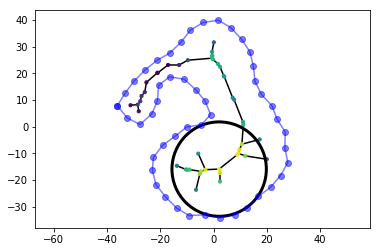

In [251]:
def inscribed_circle(contour):
    
    from scipy.spatial import Voronoi, voronoi_plot_2d
    vor = Voronoi(contour)
    voronoi_plot_2d(vor)

def skeleton(contour):
    
    # create voronoi diagram from contour
    from scipy.spatial import Voronoi, voronoi_plot_2d
    vor = Voronoi(contour)
    x, y = vor.vertices[:,0], vor.vertices[:,1]

    # get Voronoi vertices inside of contour (negative distance)
    distances = is_inside(x, y, contour)
    inside = distances < 0
    vertices_inside = vor.vertices[inside]
    distances = -distances[inside]

    # plot contour with voronoi vertices (colored by distance)
    from cellshapy.utils.contours import close_contour
    fig, ax = plt.subplots(1,1)
    contour_c = close_contour(contour)
    plt.plot(*contour_c.T, 'bo-', alpha=0.5)
    plt.scatter(*vertices_inside.T, s=10, c=distances)

    # largest inscribing circle
    index = np.argmax(distances)
    largest_distance = distances[index]
    center_circle = vertices_inside[index]
    
    from matplotlib.patches import Circle
    c = Circle(center_circle, radius=largest_distance, fill=False, linewidth=3)
    ax.add_patch(c)
    

    # get skeleton: ridges connecting vertices
    ridges = []
    distances_ridges = []
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        points = vor.vertices[simplex]
        distance = is_inside(points[:,0], points[:,1], contour)
        if np.all(simplex >= 0) and np.all(distance < 0):
            ridges.append([(x, y) for x, y in vor.vertices[simplex]])
            distances_ridges.append(distance)

    # convert to array
    skeleton = np.array([np.array(list(ridge)) for ridge in ridges])
    distances_ridges = np.array(distances_ridges)
    
    print(distances_ridges.shape)

    
    print(skeleton.shape)
    skeleton_elements = skeleton.reshape(skeleton.shape[0]*skeleton.shape[1], -1)
    print(skeleton_elements.shape)
    #print(skeleton_elements)
    print(np.unique(skeleton_elements, axis=0).shape)
    print(np.unique(skeleton_elements, axis=0))
    
    # total length of ridges
    length = np.sum([np.linalg.norm(ridge[0]-ridge[1]) for ridge in skeleton])
    sum_distances = np.mean(-distances_ridges)
    print(length) 
    print(sum_distances) 
    
    #print(ridges)
    #ax.plot(ridges)
    from matplotlib.collections import LineCollection
    lc = LineCollection(skeleton,
                        linestyle='solid',
                        color='black', zorder=0)
    ax.add_collection(lc)
    ax.axis('equal')
    #ax.axis('off')

    print(vertices_inside.shape)
    
    return vertices_inside, distances
    
contour = videos[0][45].contour
vertices, distances = skeleton(contour)

#inscribed_circle(contour)

In [306]:
def weights_vertices(vertices, distances):
    '''determine weights of vertices in skeleton 
    based on the difference in area of the reconstruction of the element is removed.
    
    See eq 2 in https://pdfs.semanticscholar.org/002b/fd0f5611a2eda15d9196441f7f9fcd945472.pdf
    '''
    
    A_original = np.count_nonzero(reconstruct_from_skeleton(vertices, distances))
    
    weights = []
    for i,(verts,dists) in enumerate(zip(vertices, distances)):
        v = np.delete(vertices, i, axis=0)
        d = np.delete(distances, i, axis=0)
        A_i = np.count_nonzero(reconstruct_from_skeleton(v, d))
        weights.append(1 - (A_i / A_original))
    return np.array(weights)
    
    
def reconstruct_from_skeleton(vertices, distances):
    '''create image from skeleton, given as vertices with distances'''
    
    from skimage.draw import circle
    max_diameter = np.max(distances)
    xmin, xmax = int(np.min(vertices[:,0])-max_diameter), int(np.max(vertices[:,0])+max_diameter)
    ymin, ymax = int(np.min(vertices[:,1])-max_diameter), int(np.max(vertices[:,1])+max_diameter)
    imsize = (xmax-xmin, ymax-ymin)
    img = np.zeros((xmax-xmin, ymax-ymin), dtype=np.uint8)
    
    for p, diam in zip(vertices, distances):
        p -= (xmin, ymin)
        rr, cc = circle(*p, diam)
        img[rr,cc] = 1
    
    return img.T

def simplify_skeleton(vertices, distances, threshold):
    weights = weights_vertices(vertices, distances)
    indices_keep = np.argwhere((weights >= threshold)).flatten()
    print(indices_keep)
    
    vertices_simple = vertices[indices_keep]
    distances_simple = distances[indices_keep]
    
    print(vertices_simple.shape)
    #print(distances_simple.shape)
    plt.imshow( reconstruct_from_skeleton(vertices_simple, distances_simple), cmap='gray_r', origin='lower')
    
    return vertices_simple, distances_simple

[ 0  1  2  4  5  6  8 11 13 14 15 16 18 19 25 28 30 31 32 33 34 40 41 42
 44 45]
(26, 2)


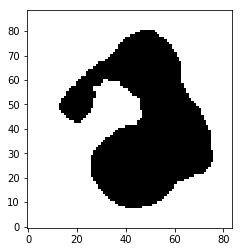

In [313]:
#weights(vertices, distances)
v, d = simplify_skeleton(vertices, distances, threshold=1e-4)
#print(v)

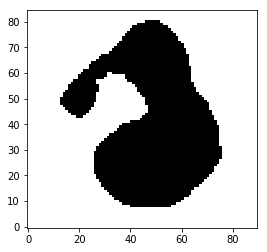

In [294]:
plt.imshow( reconstruct_from_skeleton(vertices, distances), cmap='gray_r', origin='lower')

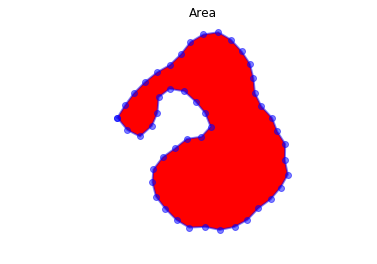

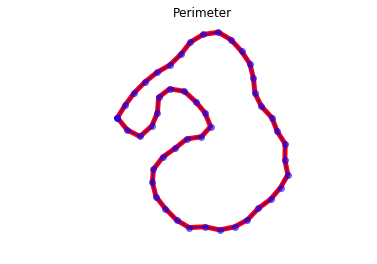

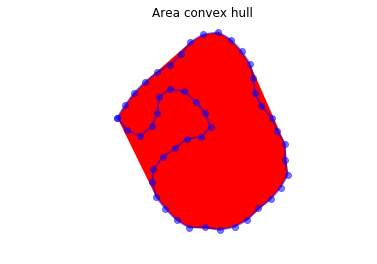

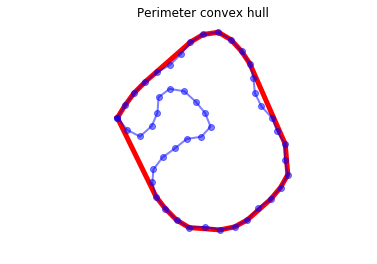

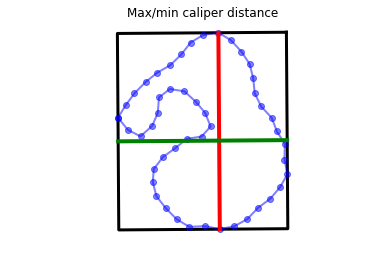

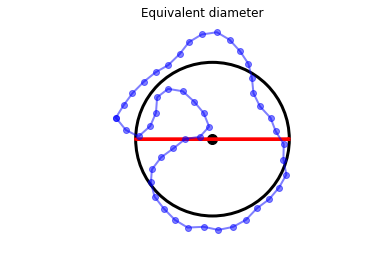

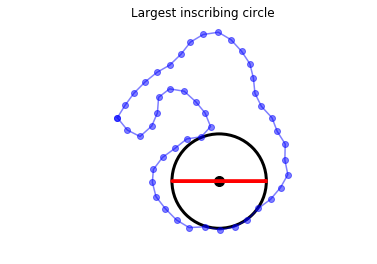

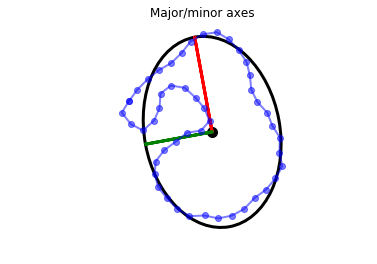

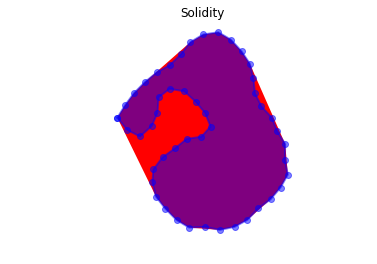

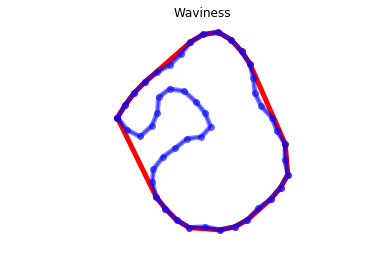

{'area': 2609.9429185922904,
 'perimeter': 270.7329669539147,
 'perimeter to area ratio': 0.10373137474590377,
 'area hull': 3170.131304221942,
 'perimeter hull': 208.30719077380743,
 'solidity': 0.8232917403504392,
 'waviness': 0.769419377024987,
 'area bbox': 4732.626834256503,
 'perimeter bbox': 275.9556855943574,
 'max caliper diameter': 74.17008357364605,
 'min caliper diameter': 63.80775922353267,
 'aspect ratio': 1.16239912631647,
 'equivalent diameter': 57.64618403201733,
 'circularity': 0.44746450188057735,
 'inscribing circle diameter': 35.41704416449634,
 'major axis length': 76.75549988807018,
 'minor axis length': 54.0198228084551,
 'eccentricity': 0.710407179439831,
 'elongation': 0.42087653155315397,
 'contour temperature': 0.32085652863760494,
 'length skeleton': 354.0,
 'number branches skeleton': 2}

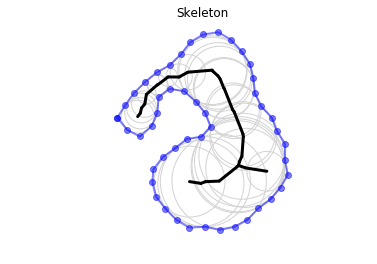

In [358]:
from cellshapy.utils.contours import extract_features
videos[0][45].extract_features(plot=True, extract_skeleton=True)
#f.extract_features(plot=True, extract_skeleton=True)

# Embedding

### PCA embeddings

In [9]:
videos.embed_frames(source='all', method='pca', n_components=2)

`pca` embedding for `features` done (0.37 s).
`pca` embedding for `contours` done (0.01 s).


# PCA plots

True False


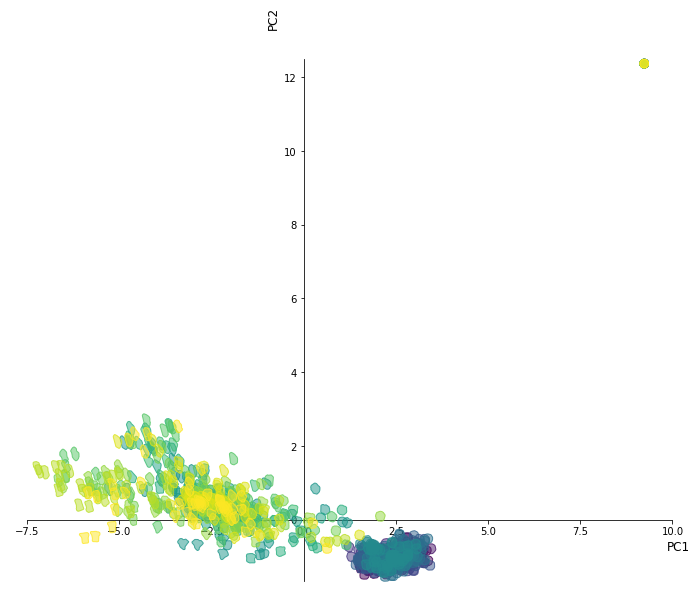

In [10]:
videos.shape_space('features', 'pca', colorcode='video', shape_size=3, 
                   show_shapes=True, show_trajectories=False,
                   alpha_face=.5, alpha_edge=.8)

True False


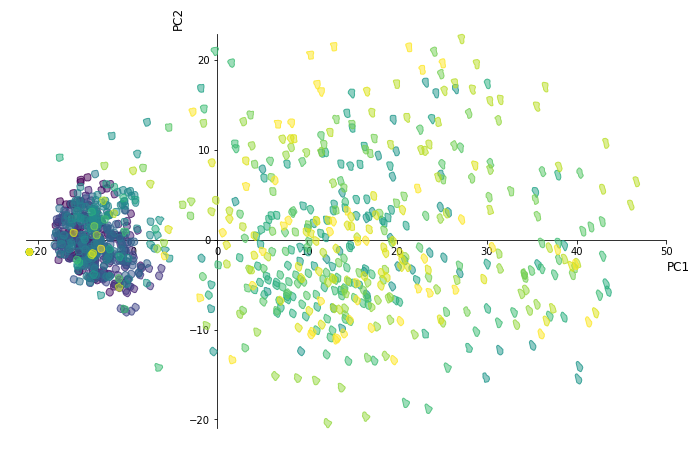

In [11]:
videos.shape_space('contours', 'pca', colorcode='video', shape_size=3, reconstruction=False,
                   show_shapes=True, show_trajectories=False,
                   alpha_face=.5, alpha_edge=.8)

embedding.shape[-1] :  2
True False


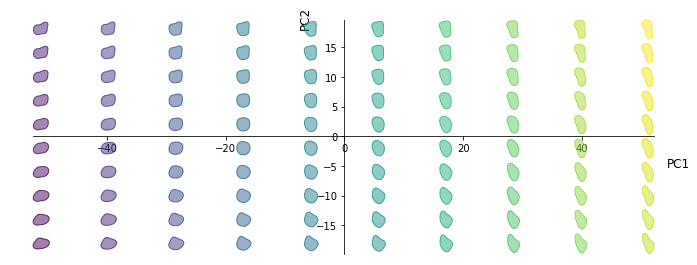

In [12]:
videos.shape_space('contours', 'pca', colorcode='video', shape_size=10, reconstruction=True,
                   show_shapes=True, show_trajectories=False,
                   alpha_face=.5, alpha_edge=.8)

True True



(50, 2, 2)


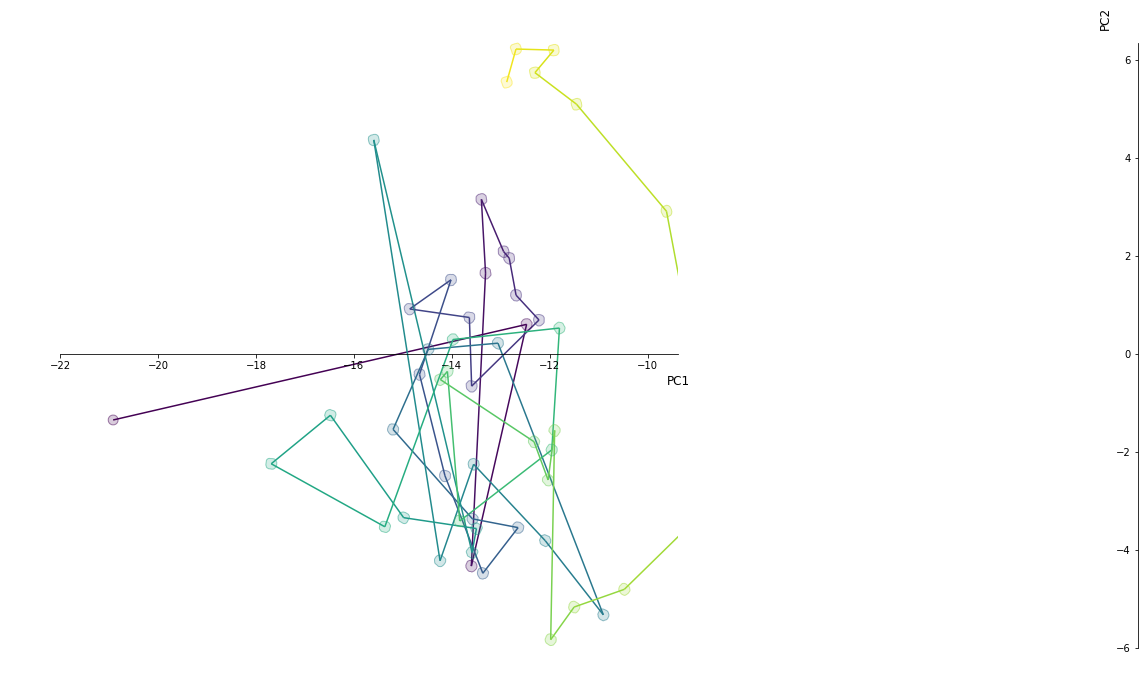

In [13]:
indices = [1]
selection = cellshapy.VideoCollection()
selection.videos = [videos[i] for i in indices]
selection.shape_space('contours', 'pca', colorcode='frame', shape_size=3, 
                   show_shapes=True, show_trajectories=True)

## Polar PCA plot

/home/debacwa/miniconda3/envs/cellshapy/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


pearsonr  rotation (degree)  rotation (rad)
elongation               0.590422           0.987840        0.017241
major_axis_length        0.588401           1.569428        0.027392
minor_axis_length        0.575649        -179.796063       -3.138033
max_feret                0.574896          -1.598076       -0.027892
eccentricity             0.564320           0.623725        0.010886
circularity              0.537926        -177.071755       -3.090485
perimeter                0.515507           3.339752        0.058290
area_to_perimeter_ratio  0.482147        -177.285284       -3.094212
perimeter convex hull    0.433199           7.327717        0.127893
solidity                 0.368381        -167.139729       -2.917139
extent                   0.360460        -167.565063       -2.924562
convex_area              0.255142          10.823072        0.188898
waviness                 0.105806         -34.038487       -0.594084
area                     0.104507           6.079000        0.106099
filled_area              0.104507           6.079000        0.106099
equivalent_diameter      0.104449           6.080728        0.106129

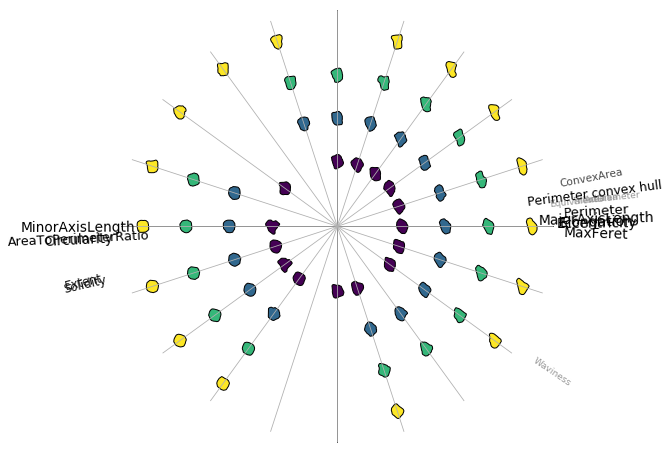

In [14]:
df, _ = videos.polar_shape_space(source='contours', method='pca', shape_size=5.0, num_quantiles=4,
                         num_bins=20, label_threshold=0.00, alpha_face=1.0)
df

# Video analysis

- Tensor decomposition
- Time series of features
- Trajectories in shape space 

### Create video embedding using parafac

In [23]:
videos.embed_videos(format='stxy', method='parafac', n_components=4)

`parafac` embedding for `stxy` done (0.11 s).


(20, 51, 96)
5 5
....................

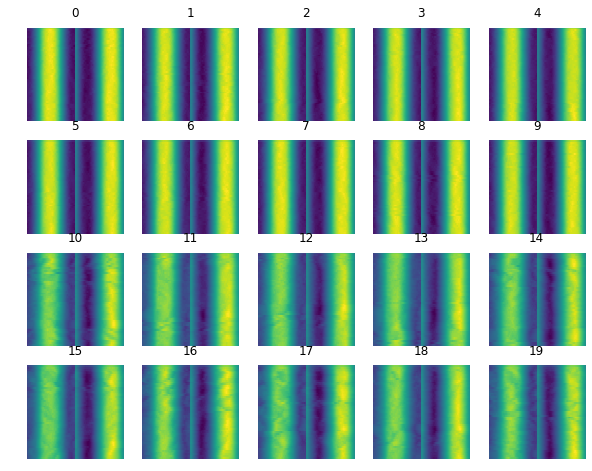

In [26]:
t = videos.tensor[('stxy', 'parafac')]
print(t.shape)

from cellshapy.plotting import tensor
_ = tensor.plot_tensor_2D(videos.tensor[('stxy', 'parafac')])

### Visualize morph space

num_videos =  20
num_frames =  51


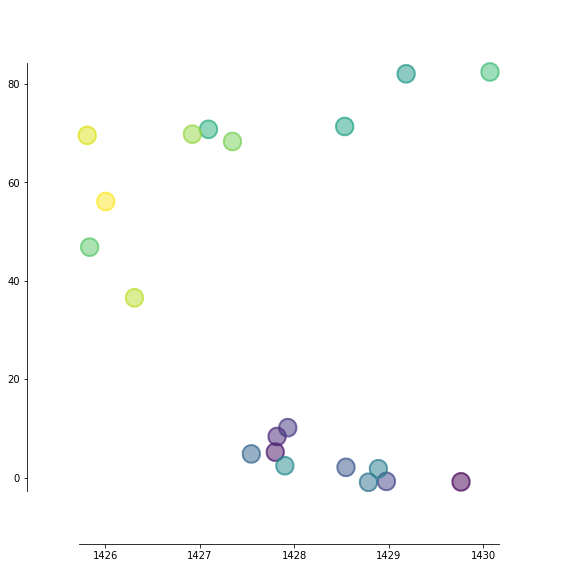

In [28]:
anim = videos.morph_space(format='stxy', method='parafac', shape_size=2.0, duration=8.0, alpha_face=0.5, colorcode='video')


In [29]:
HTML(anim.to_html5_video())

In [30]:
#videos.embed_videos(format='stxy', method='parafac', n_components=3)
factors = videos.embedding['stxy', 'parafac']

def _norm(val, vmin, vmax):
    if vmin == max: return 1.0
    else: return (float(val) - vmin) / float(vmax - vmin)

values = [v.annotations['video'] for v in videos]
print(values)
colors = [plt.cm.viridis(_norm(val, 0, np.max(values))) for val in values]
print(colors)
print(factors[0].shape)

f = 0
import ipyvolume.pylab as p3
p3.clear()
p3._grow_limits = lambda *ignore: None
p3.scatter(*factors[f][:,:3].T, color=colors, marker='sphere', size=10)
p3.xlim(np.min(factors[f][:,0]), np.max(factors[f][:,0]))
p3.ylim(np.min(factors[f][:,1]), np.max(factors[f][:,1]))
p3.zlim(np.min(factors[f][:,2]), np.max(factors[f][:,2]))
p3.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[(0.267004, 0.004874, 0.329415, 1.0), (0.280894, 0.078907, 0.402329, 1.0), (0.28229, 0.145912, 0.46151, 1.0), (0.270595, 0.214069, 0.507052, 1.0), (0.250425, 0.27429, 0.533103, 1.0), (0.223925, 0.334994, 0.548053, 1.0), (0.19943, 0.387607, 0.554642, 1.0), (0.175841, 0.44129, 0.557685, 1.0), (0.15627, 0.489624, 0.557936, 1.0), (0.136408, 0.541173, 0.554483, 1.0), (0.121831, 0.589055, 0.545623, 1.0), (0.12478, 0.640461, 0.527068, 1.0), (0.162016, 0.687316, 0.499129, 1.0), (0.239374, 0.735588, 0.455688, 1.0), (0.335885, 0.777018, 0.402049, 1.0), (0.458674, 0.816363, 0.329727, 1.0), (0.585678, 0.846661, 0.249897, 1.0), (0.730889, 0.871916, 0.156029, 1.0), (0.866013, 0.889868, 0.095953, 1.0), (0.993248, 0.906157, 0.143936, 1.0)]
(20, 4)


`parafac` embedding for `stxy` done (0.11 s).
original tensor =  (20, 51, 48, 48)
reconstruct_tensor embedding.shape:  [(20, 5), (51, 5), (96, 5)]
reconstruct_tensor reconstruction.shape:  (243, 51, 96)
16 16
...................................................................................................................................................................................................................................................format =  stxy
num_videos =  243
num_frames =  51


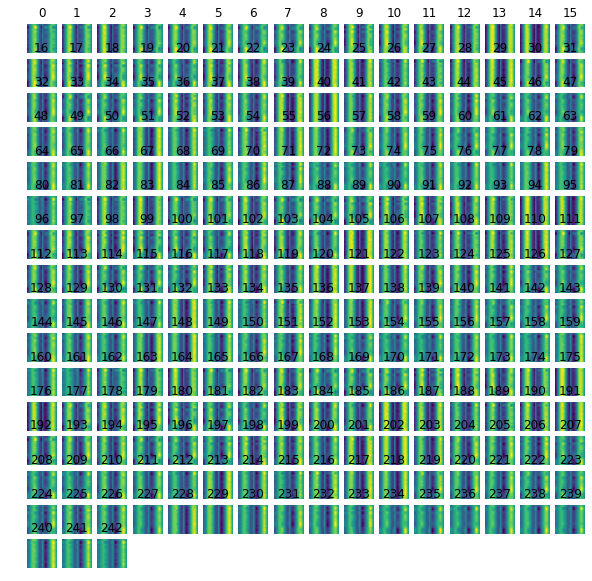

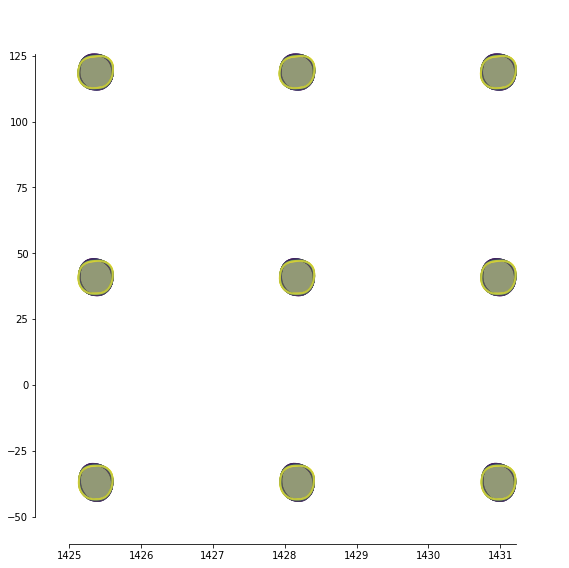

In [36]:
videos.embed_videos(format='stxy', method='parafac', n_components=5)
print('original tensor = ', videos.tensor[('stp', 'parafac')].shape)
anim = videos.morph_space(format='stxy', method='parafac', reconstruction=True, shape_size=3, duration=8.0, alpha_face=0.05, colorcode='video')
#HTML(anim.to_html5_video())

In [37]:
HTML(anim.to_html5_video())

## Reconstruct n samples within convex hull   

IDEA:

1. Get convex hull of samples per labelled set of videos
2. Create $n$ probes within these convex hulls
3. Reconstruct the contours for these probes
4. Perform a cluster comparison for these recontructed contours  

We typically have too few samples to do decent comparison. This methods allows us to blow up the number of samples, using the TD approximations. 

`parafac` embedding for `stxy` done (0.13 s).
(20, 51, 96)
(50, 6)
(50, 6)
format =  stxy
format =  stxy


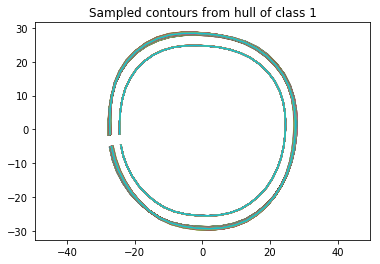

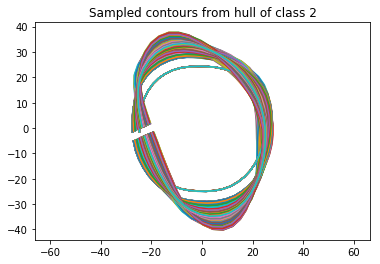

In [22]:
##### embed videos in n-dimensional space #####
n = 6
videos.embed_videos(format='stxy', method='parafac', n_components=n)
print(videos.tensor[('stxy', 'parafac')].shape)

# get the n-dimensional embedding
embedding = videos.embedding[('stxy', 'parafac')]
embedding1 = embedding[0][:10] # positions for class 1
embedding2 = embedding[0][10:] # positions for class 2
#print(embedding1)

##### create convex hulls around embedding points #####
from scipy.spatial import Delaunay
hull1 = Delaunay(embedding1)
hull2 = Delaunay(embedding2)

#print(hull1.ndim)
#print(hull1.min_bound)
#print(hull1.max_bound)

##### generate number of randomly distributed points within hull #####

def in_hull(p, hull):
    """
    https://stackoverflow.com/a/16898636
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

def sample_point_in_hull(hull, n=50, max_iter=10240):
    
    samples = np.empty((0, hull.ndim))
    
    c = 0
    while samples.shape[0] < n:
        c += 1
        batch = np.random.random((n*10, hull.ndim)) * (hull.max_bound - hull.min_bound) + hull.min_bound
        batch = batch[in_hull(batch, hull)]
        samples = np.append(samples, batch, axis=0)
        if c > max_iter:
            raise ValueError('Number of iteration ({}) > max_iter ({})'.format(c, max_iter))
        
    return np.array(samples)[:n]

samples1 = sample_point_in_hull(hull1, n=50)
samples2 = sample_point_in_hull(hull2, n=50)

print(samples1.shape)
print(samples2.shape)

##### reconstruct tensors from these samples #####
import tensorly as tl
tensor_recon1 = tl.kruskal_to_tensor([samples1, *embedding[1:]])
tensor_recon2 = tl.kruskal_to_tensor([samples2, *embedding[1:]])

#from cellshapy.plotting import tensor
#_ = tensor.plot_tensor_2D(tensor_recon1)
#plt.show()
#_ = tensor.plot_tensor_2D(tensor_recon2)


#### convert back to contours ####

from cellshapy.analysis.embedding import tensor_to_contours
contours1 = tensor_to_contours(tensor_recon1, format='stxy')
contours2 = tensor_to_contours(tensor_recon2, format='stxy')

for contour_over_time in contours1:
    for contour in contour_over_time: 
        plt.title('Sampled contours from hull of class 1')
        plt.plot(*contour.T)
        plt.axis('equal')
plt.show()

for contour_over_time in contours2:
    for contour in contour_over_time: 
        plt.title('Sampled contours from hull of class 2')
        plt.plot(*contour.T)
        plt.axis('equal')
plt.show()



### Clustering

In [ ]:
df_clustering = videos.cluster_videos(format='stxy', method='parafac', n_clusters=2, cl_method='kmeans', plot=True)
df_clustering

In [ ]:
videos.cluster_comparison(alpha=0.05)

----
----
----
----

### Compare clusters

In [ ]:
[i for i in df_clustering['cluster_video'].unique()]

In [ ]:
import pandas as pd
clusters_indices = [df_clustering.query('cluster_video == {}'.format(i))['video'].values for i in df_clustering['cluster_video'].unique()]
clusters_indices

df_clusters = dict()
for i, indices in enumerate(clusters_indices):
    print('Cluster {}'.format(i))
    cluster = cellshapy.VideoCollection()
    cluster.videos = [videos[i] for i in indices]
    df1 = cluster.analyse_shape_space_trajectories()
    df2 = cluster.analyse_features_time_series()
    df_cluster = pd.concat([df1, df2], axis=1)
    df_clusters[i] = df_cluster
#df_clusters

In [ ]:
from scipy.stats import kruskal

## Kruskal test 

alpha = 0.05
p_vals = dict()
for col in list(df_clusters.values())[0].columns:
    # get data from column
    series = [df[col] for df in list(df_clusters.values()) ]
    # skip data with only continuous values
    if all([len(s.unique()) < 2 for s in series]):
        continue

    # do kruskal test
    _, p = kruskal(*series)
    p_vals[col] = p

## Multiple testing adjustment
from statsmodels.stats import multitest
#reject, p_vals_corr, _, alpha_bonf = multitest.multipletests(list(p_vals.values()), alpha=alpha, method='bonferroni') 
reject, p_vals_corr, _, alpha_bonf = multitest.multipletests(list(p_vals.values()), alpha=alpha, method='fdr_bh') # Benjamin-Hochberg
print('Adjusted alpha:', alpha_bonf)

p_vals_corr = dict(zip(list(p_vals.keys()), p_vals_corr))
significant_features = dict(zip(list(p_vals.keys()), reject))

plot = False
## Show significant results
for (col, p), (col, significant) in zip(p_vals_corr.items(), significant_features.items()):
    
    if significant:
        print('{} : {:<20.3f}'.format(col, p))
        series = [df[col] for df in df_clusters.values()]
        import numpy as np
        
        tics = list(range(1, len(series)+1))
        means = [s.values.mean() for s in series]
        std = [s.values.std() for s in series]

        if plot:
            fig, ax = plt.subplots(1,1,figsize=(4,4))
            _ = ax.boxplot( series )
            ax.set_xticks(list(range(1, len(series)+1)), df_clusters.keys())
            _ = ax.set_title('{}, p = {:.5f}'.format(col, p))
        
        if len(df_clusters) > 2:
            ## Post-hoc test: mann whitley U test per group pairs
            # per significant feature, test groups

            import itertools
            combinations_indices = list(itertools.combinations(df_clusters.keys(), 2))
            combinations_data = list(itertools.combinations(series, 2))
            print(combinations_indices)

            from scipy.stats import mannwhitneyu 
            for ind, groups in zip(combinations_indices, combinations_data):
                _, p = mannwhitneyu(*groups, alternative='two-sided')

                if p < alpha:
                    print('Groups {} are different {:.3f}'.format(ind, p))
                else:
                    print('Groups {} are NOT significantly different: {:.3f}'.format(ind, p))

        plt.show()


In [ ]:
df_results.sort_values(ascending=True)

In [ ]:
from matplotlib.text import Text
import matplotlib.pyplot as plt
from matplotlib import transforms, lines
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn.utils import remove_na

from scipy import stats


def stat_test(box_data1, box_data2, test):
    testShortName = ''
    formattedOutput = None
    if test == 'Mann-Whitney':
        u_stat, pval = stats.mannwhitneyu(box_data1, box_data2, alternative='two-sided')
        testShortName = 'M.W.W.'
        formattedOutput = "MWW RankSum two-sided P_val={:.3e} U_stat={:.3e}".format(pval, u_stat)
    elif test == 't-test':
        stat, pval = stats.ttest_ind(a=box_data1, b=box_data2)
        testShortName = 't-test'
        formattedOutput = "t-test independent samples, P_val={:.3e} stat={:.3e}".format(pval, stat)
    
    return pval, formattedOutput, testShortName



def pvalAnnotation_text(x, pvalueThresholds):
    singleValue = False
    if type(x) is np.array:
        x1 = x
    else:
        x1 = np.array([x])
        singleValue = True
    # Sort the threshold array
    pvalueThresholds = pd.DataFrame(pvalueThresholds).sort_values(by=0, ascending=False).values
    xAnnot = pd.Series(["" for _ in range(len(x1))])
    for i in range(0, len(pvalueThresholds)):
        if (i < len(pvalueThresholds)-1):
            condition = (x1 <= pvalueThresholds[i][0]) & (pvalueThresholds[i+1][0] < x1)
            xAnnot[condition] = pvalueThresholds[i][1]
        else:
            condition = x1 < pvalueThresholds[i][0]
            xAnnot[condition] = pvalueThresholds[i][1]

    return xAnnot if not singleValue else xAnnot.iloc[0]


def add_stat_annotation(ax,
                        data=None, x=None, y=None, hue=None, order=None, hue_order=None,
                        boxPairList=None,
                        test='Mann-Whitney', textFormat='star', loc='inside',
                        pvalueThresholds=[[1e9,"ns"], [0.05,"*"], [1e-2,"**"], [1e-3,"***"], [1e-4,"****"]],
                        color='0.2', lineYOffsetAxesCoord=None, lineHeightAxesCoord=0.02, yTextOffsetPoints=1,
                        linewidth=1.5, fontsize='medium', verbose=1):
    """
    User should use the same argument for the data, x, y, hue, order, hue_order as the seaborn boxplot function.
    
    boxPairList can be of either form:
    For non-grouped boxplot: [(cat1, cat2), (cat3, cat4)]
    For boxplot grouped by hue: [((cat1, hue1), (cat2, hue2)), ((cat3, hue3), (cat4, hue4))]
    """

    def find_x_position_box(boxPlotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        """
        if boxPlotter.plot_hues is None:
            cat = boxName
            hueOffset = 0
        else:
            cat = boxName[0]
            hue = boxName[1]
            hueOffset = boxPlotter.hue_offsets[boxPlotter.hue_names.index(hue)]

        groupPos = boxPlotter.group_names.index(cat)
        boxPos = groupPos + hueOffset
        return boxPos

    
    def get_box_data(boxPlotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        
        Here we really have to duplicate seaborn code, because there is not direct access to the
        box_data in the BoxPlotter class.
        """
        if boxPlotter.plot_hues is None:
            cat = boxName
        else:
            cat = boxName[0]
            hue = boxName[1]

        i = boxPlotter.group_names.index(cat)
        group_data = boxPlotter.plot_data[i]

        if boxPlotter.plot_hues is None:
            # Draw a single box or a set of boxes
            # with a single level of grouping
            box_data = remove_na(group_data)
        else:
            hue_level = hue
            hue_mask = boxPlotter.plot_hues[i] == hue_level
            box_data = remove_na(group_data[hue_mask])

        return box_data
    
    
    validList = ['inside', 'outside']
    if loc not in validList:
        raise ValueError("loc value should be one of the following: {}.".format(', '.join(validList)))
    validList = ['t-test', 'Mann-Whitney']
    if test not in validList:
        raise ValueError("test value should be one of the following: {}.".format(', '.join(validList)))

    if verbose >= 1 and textFormat == 'star':
        print("pvalue annotation legend:")
        pvalueThresholds = pd.DataFrame(pvalueThresholds).sort_values(by=0, ascending=False).values
        for i in range(0, len(pvalueThresholds)):
            if (i < len(pvalueThresholds)-1):
                print('{}: {:.2e} < p <= {:.2e}'.format(pvalueThresholds[i][1], pvalueThresholds[i+1][0], pvalueThresholds[i][0]))
            else:
                print('{}: p <= {:.2e}'.format(pvalueThresholds[i][1], pvalueThresholds[i][0]))
        print()

    # Create the same BoxPlotter object as seaborn's boxplot
    boxPlotter = sns.categorical._BoxPlotter(x, y, hue, data, order, hue_order,
                                             orient=None, width=.8, color=None, palette=None, saturation=.75,
                                             dodge=True, fliersize=5, linewidth=None)
    plotData = boxPlotter.plot_data
    
    xtickslabels = [t.get_text() for t in ax.xaxis.get_ticklabels()]
    ylim = ax.get_ylim()
    yRange = ylim[1] - ylim[0]
    if loc == 'inside':
        lineYOffsetAxesCoord = 0.05
    elif loc == 'outside':
        lineYOffsetAxesCoord = 0.03
    yOffset = lineYOffsetAxesCoord*yRange

    yStack = []
    annList = []
    for box1, box2 in boxPairList:
        
        valid = None
        groupNames = boxPlotter.group_names
        hueNames = boxPlotter.hue_names
        if boxPlotter.plot_hues is None:
            cat1 = box1
            cat2 = box2
            hue1 = None
            hue2 = None
            label1 = '{}'.format(cat1)
            label2 = '{}'.format(cat2)
            valid = cat1 in groupNames and cat2 in groupNames
        else:
            cat1 = box1[0]
            hue1 = box1[1]
            cat2 = box2[0]
            hue2 = box2[1]
            label1 = '{}_{}'.format(cat1, hue1)
            label2 = '{}_{}'.format(cat2, hue2)
            valid = cat1 in groupNames and cat2 in groupNames and hue1 in hueNames and hue2 in hueNames
        
        
        if valid:
            # Get position of boxes
            x1 = find_x_position_box(boxPlotter, box1)
            x2 = find_x_position_box(boxPlotter, box2)
            box_data1 = get_box_data(boxPlotter, box1)
            box_data2 = get_box_data(boxPlotter, box2)
            ymax1 = box_data1.max()
            ymax2 = box_data2.max()

            pval, formattedOutput, testShortName = stat_test(box_data1, box_data2, test)
            if verbose >= 2: print ("{} v.s. {}: {}".format(label1, label2, formattedOutput))

            if textFormat == 'full':
                text = "{} p < {:.2e}".format(testShortName, pval)
            elif textFormat is None:
                text = None
            elif textFormat is 'star':
                text = pvalAnnotation_text(pval, pvalueThresholds)
            
            if loc == 'inside':
                yRef = max(ymax1, ymax2)
            elif loc == 'outside':
                yRef = ylim[1]

            if len(yStack) > 0:
                yRef2 = max(yRef, max(yStack))
            else:
                yRef2 = yRef
                
            y = yRef2 + yOffset
            h = lineHeightAxesCoord*yRange
            lineX, lineY = [x1, x1, x2, x2], [y, y + h, y + h, y]
            if loc == 'inside':
                ax.plot(lineX, lineY, lw=linewidth, c=color)
            elif loc == 'outside':        
                line = lines.Line2D(lineX, lineY, lw=linewidth, c=color, transform=ax.transData)
                line.set_clip_on(False)
                ax.add_line(line)
            
            if text is not None:
                ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                                  xytext=(0, yTextOffsetPoints), textcoords='offset points',
                                  xycoords='data', ha='center', va='bottom', fontsize=fontsize,
                                  clip_on=False, annotation_clip=False)
                annList.append(ann)
                
            ax.set_ylim((ylim[0], 1.1*(y + h)))
            
            if text is not None:
                plt.draw()
                bbox = ann.get_window_extent()
                bbox_data = bbox.transformed(ax.transData.inverted())
                yTopAnnot = bbox_data.ymax
            else:
                yTopAnnot = y + h

            yStack.append(yTopAnnot)
        else:
            raise ValueError("boxPairList contains an unvalid box pair.")
            pass
            
        
    yStackMax = max(yStack)
    if loc == 'inside':
        ax.set_ylim((ylim[0], 1.03*yStackMax))
    elif loc == 'outside':
        ax.set_ylim((ylim[0], ylim[1]))
    
    return ax


In [ ]:
from scipy.stats import kruskal

df_cluster0 = df_cluster[0]
df_cluster1 = df_cluster[1]

## Kruskal test 

alpha = 0.05
p_vals = dict()
for col in df_cluster0.columns:
    if len(df_cluster0[col].unique()) < 2 and len(df_cluster1[col].unique()) < 2:
        continue
        
    _, p = kruskal(df_cluster0[col], df_cluster1[col])
    p_vals[col] = p

from statsmodels.stats import multitest
reject, p_vals_corr, _, alpha_bonf = multitest.multipletests(list(p_vals.values()), alpha=alpha, method='bonferroni')
print('Adjusted alpha:', alpha_bonf)

p_vals_corr = dict(zip(list(p_vals.keys()), p_vals_corr))
rejected = dict(zip(list(p_vals.keys()), reject))
#print(p_vals_corr)

## Show significant results

for (col, p), (col, rej) in zip(p_vals_corr.items(), rejected.items()):
    
    #print(p, alpha_bonf)
    if rej:
        print('{} : {:<20.3f}'.format(col, p))
        
        _ = plt.boxplot( [df_ts_0[col], df_ts_1[col]] )
        _ = plt.title('{}, p = {:.5f}'.format(col, p))
        plt.show()



In [ ]:
from statsmodels.stats import multitest
multitest.multipletests(p_vals, method='bonferroni')

In [ ]:
print(df_ts_0.columns)

In [ ]:
import seaborn as sns
ax = sns.boxplot(x="day", y="total_bill", data=ttest_ind)
ax = sns.swarmplot(x="day", y="total_bill", data=tips, color=".25")

In [ ]:
import hdbscan

In [ ]:
import numpy.lib.recfunctions
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=False)
clusterer.fit(video_embedding)

In [ ]:
clusterer.minimum_spanning_tree_(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

In [ ]:
videos.analyse_shape_space_trajectories(source='contours', method='pca')

In [ ]:
from scipy.spatial import ConvexHull

In [ ]:
videos[0].frames[0].embedding[('contours', 'pca')]
len(videos[0].frames)

In [ ]:

results = []
for video in videos:
    trajectory = np.array([video.frames[f].embedding[('contours', 'pca')] for f in range(len(video.frames))])    
    result = cellshapy.analysis.timeseries.analyse_trajectories(trajectory)
    result['video'] = video.annotations['video']
    results.append(result)
    
import pandas as pd
df_stats = pd.DataFrame(results)
df_stats = df_stats.set_index('video')
df_stats

In [ ]:
pd.zscore()

In [ ]:
from scipy.spatial import ConvexHull
points = trajectory
hull = ConvexHull(points)
import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

In [ ]:
np.median(trajectory, axis=0).shape

In [ ]:
trajectory = np.random.normal(size=(500,2))

In [ ]:
def reject_outliers(data, m = 1.):
    from scipy.spatial.distance import pdist, squareform
    d = pdist(data)
    mean_dist = np.mean(d)
    mean_pdist = np.mean(squareform(d), axis=0)
    indices = np.argwhere(mean_pdist < m*mean_dist).flatten()
    #print(indices)
    return data[indices]

from scipy.spatial import ConvexHull
points = reject_outliers(trajectory)
print(trajectory.shape)
print(points.shape)
hull = ConvexHull(points)
import matplotlib.pyplot as plt
plt.plot(trajectory[:,0], trajectory[:,1], 'o')
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

In [ ]:
from scipy.spatial import ConvexHull
points = trajectory #np.random.rand(30, 2)   # 30 random points in 2-D
hull = ConvexHull(points)
print(hull.volume)
#import matplotlib.pyplot as plt
#plt.plot(points[:,0], points[:,1], 'o')
#for simplex in hull.simplices:
#    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

In [ ]:
def _length_trajectory(coords):
    # compute length of trajectory
    displacements = np.diff(coords, n=1, axis=0)
    lengths = np.linalg.norm(displacements, ord=2, axis=-1)
    length_trajectory = np.sum(lengths)
    return length_trajectory

def _length_trajectory(coords):
    # compute length of trajectory
    displacements = np.diff(coords, n=1, axis=0)
    lengths = np.linalg.norm(displacements, ord=2, axis=-1)
    length_trajectory = np.sum(lengths)
    return length_trajectory

In [ ]:
def analyse_trajectories(coords):

    length = _length_trajectory(coords)
    


In [ ]:
coords = np.array([[0,0], [1,1], [2,2.3], [3,3]])
analyse_trajectories(coords)

## 0. Plot tensor

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

def plot_tensor_3D(tensor, n_slices=5, 
                       color_resolution=1.0, cmap='viridis',
                       title=None, labels=['', '', ''], fontsize=14, show_ticks=True,
                       figsize=(10,7.5), show_grid=True, show_white_background=True,
                       viewpoint_elev=25, viewpoint_azim=30,
                       filename=None):
    '''
    Plot 3D tensor as 2D slices in 3D space.
    
    Note: tensor must be provided in `channels_last` format (X, Y, C).
    
    https://stackoverflow.com/a/15583431/6198865
    
    Args:
    - tensor (ndarray, ndim=3): 3D tensor in `channel-last` format (last channel is plotted over z axis)
    - n_slices (int, 5): number of slices to plot
    - color_resolution (float, 1.0): resolution of color map, controls contourf's `levels` argument
    - title (str): title shown above figure
    - labels ([str, str, str]): labels for each axis
    - fontsize (float): size of labels and title (title fontsize is 25% larger)
    - figsize (tuple(width, height)): size of figure
    - show_grid (bool, False): if true, shows grid
    - show_white_background (bool, True): show white background panes
    - show_colored_panes (bool, False): show colored background panes
    - viewpoint_elev (int, 25): elevation of viewpoint
    - viewpoint_azim (int, 30): azimuth of viewpoint
    
    Returns:
    - matplotlib figure

    Example:
    ```
    plot_tensor_slices(tensor, n_slices=5, level_interval=5.0, figsize=(10,7.5))

    ```
    '''
    assert tensor.ndim == 3, 'Tensor must be 3D, but {:d}D tensor given'.format(tensor.ndim)
    
    from mpl_toolkits.mplot3d import Axes3D

    #### Plot ###
    
    fig = plt.figure(figsize=figsize)
    fig.tight_layout()
    
    ax = fig.gca(projection='3d')

    # Get rid of colored axes planes
    # First remove fill
    if show_white_background:
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')

    # Get rid of the grid as well:
    if not show_grid:
        ax.grid(False)
    
    # get rid of ticks
    if not show_ticks:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    # Set view angle
    ax.view_init(elev=25, azim=30)

    # Set axis limits
    ax.set_xlim((0, tensor.shape[0]))
    ax.set_ylim((0, tensor.shape[1]))
    ax.set_zlim((0, tensor.shape[2]))

    # Set axis labels
    if show_ticks:
        pad_labels = 12.5 # move away from axis
    else: 
        pad_labels = -10.0 # move closer to axis
    ax.set_xlabel(labels[0], fontsize=fontsize, labelpad=pad_labels)
    ax.set_ylabel(labels[1], fontsize=fontsize, labelpad=pad_labels)
    ax.set_zlabel(labels[2], fontsize=fontsize, labelpad=pad_labels, rotation=90)
    
    
    # Set figure title
    if title is not None:
        fig.suptitle(title, fontsize=fontsize*1.25, y=0.9)
        
    ### Data ###

    # set sequence of slices
    max_slice = tensor.shape[-1]
    slices = np.round(np.linspace(start=0, stop=max_slice-1, num=n_slices)).astype(np.int)
    print(slices)

    # grid points
    X = np.arange(0, tensor.shape[0], 1)
    Y = np.arange(0, tensor.shape[1], 1)
    X, Y = np.meshgrid(X, Y);

    levels = np.arange(tensor.min(), tensor.max(), color_resolution)
    print(levels)
    # plot slices with contourf 
    for i in slices:
        tensor_slice = tensor[:,:,i].T
        #ax.contourf3D(X, Y, tensor_slice, zdir='z', offset=i, cmap=cmap, levels=levels)
        ax.plot_surface(X, Y, tensor_slice, rstride=1, cstride=1, facecolors=plt.cm.BrBG(tensor_slice), shade=False)
    # save to file
    if filename is not None:
        fig.savefig(filename, dpi=300, transparent=True)
        print('Figure saved to {}'.format(filename))
    
    return fig

def plot_tensor_2D(tensor):
    # plot tensor
    nr = int(np.ceil(np.sqrt(len(tensor))))
    nc = nr
    print(nr, nc)
    fig, ax = plt.subplots(nr, nc, figsize=(10,10), sharex=True, sharey=True)
    ax = ax.flatten()
    for i,t in enumerate(tensor):
        print('.', end='')
        #xy = np.concatenate([t[:,:,0], t[:,:,1]], axis=1)
        #xy = np.concatenate([t[:,:,0], t[:,:,1]], axis=1)
        ax[i].matshow(t,cmap='viridis',aspect='auto')
        #ax[i].matshow(xy,cmap=plt.get_cmap('viridis_r'))
        ax[i].set_title(i)
        ax[i].axis('off')
    for j in range(i+1, len(ax)):
        ax[j].set_visible(False)

In [ ]:
## using plot_surface instead of contourf

def plot_tensor_3D2(tensor, n_slices=5, 
                       color_resolution=1.0, cmap='viridis',
                       title=None, labels=['', '', ''], format=None, alpha=1.0, fontsize=14, show_ticks=True,
                       figsize=(10,7.5), show_grid=True, show_white_background=True,
                       viewpoint_elev=25, viewpoint_azim=30,
                       filename=None):
    '''
    Plot 3D tensor as 2D slices in 3D space.
    
    Note: tensor must be provided in `channels_last` format (X, Y, C).
    
    https://stackoverflow.com/a/15583431/6198865
    
    Args:
    - tensor (ndarray, ndim=3): 3D tensor in `channel-last` format (last channel is plotted over z axis)
    - n_slices (int, 5): number of slices to plot
    - color_resolution (float, 1.0): resolution of color map, controls contourf's `levels` argument
    - title (str): title shown above figure
    - format (str): tensor format, one of ['stf', 'stxy3d', 'stxy4d']
    - labels ([str, str, str]): labels for each axis
    - fontsize (float): size of labels and title (title fontsize is 25% larger)
    - figsize (tuple(width, height)): size of figure
    - show_grid (bool, False): if true, shows grid
    - show_white_background (bool, True): show white background panes
    - show_colored_panes (bool, False): show colored background panes
    - viewpoint_elev (int, 25): elevation of viewpoint
    - viewpoint_azim (int, 30): azimuth of viewpoint
    
    Returns:
    - matplotlib figure

    Example:
    ```
    plot_tensor_slices(tensor, n_slices=5, level_interval=5.0, figsize=(10,7.5))

    ```
    '''
    assert tensor.ndim == 3, 'Tensor must be 3D, but {:d}D tensor given'.format(tensor.ndim)
    
    import numpy as np
    import matplotlib.pylab as plt
    from mpl_toolkits.mplot3d import Axes3D

    #### Plot ###
    
    fig = plt.figure(figsize=figsize)
    fig.tight_layout()
    
    ax = fig.gca(projection='3d')

    # Get rid of colored axes planes
    # First remove fill
    if show_white_background:
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')

    # Get rid of the grid as well:
    if not show_grid:
        ax.grid(False)
    
    # get rid of ticks
    if not show_ticks:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    # Set view angle
    ax.view_init(elev=25, azim=30)

    # Set axis limits
    ax.set_xlim((0, tensor.shape[2]))
    ax.set_ylim((0, tensor.shape[1]))
    ax.set_zlim((0, tensor.shape[0]))

    if format == 'stf':
        labels = ['features', 'time', 'samples']
    if format == 'stxy3d':
        labels = ['(x,y)', 'time', 'samples']
    if format == 'stp':
        labels = ['pairwise distance', 'pairwise distance', 'time']
    
    # Set axis labels
    if show_ticks:
        pad_labels = 12.5 # move away from axis
    else: 
        pad_labels = -10.0 # move closer to axis
    ax.set_xlabel(labels[0], fontsize=fontsize, labelpad=pad_labels)
    ax.set_ylabel(labels[1], fontsize=fontsize, labelpad=pad_labels)
    ax.set_zlabel(labels[2], fontsize=fontsize, labelpad=pad_labels, rotation=90)
    
    
    # Set figure title
    if title is not None:
        fig.suptitle(title, fontsize=fontsize*1.25, y=0.9)
        
    ### Data ###

    # set sequence of slices
    max_slice = tensor.shape[0]
    slices = np.round(np.linspace(start=0, stop=max_slice-1, num=n_slices)).astype(np.int)
    print(slices)

    # grid points
    X = np.arange(0, tensor.shape[2], 1)
    Y = np.arange(0, tensor.shape[1], 1)
    X, Y = np.meshgrid(X, Y)

    # plot slices with contourf 
    for i in slices:
        tensor_slice = tensor[i]
        Z = i*np.ones(X.shape)
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=plt.get_cmap(cmap)(tensor_slice/tensor_slice.max()), shade=False, alpha=alpha)

    # save to file
    if filename is not None:
        fig.savefig(filename, dpi=300, transparent=True)
        print('Figure saved to {}'.format(filename))
    
    return fig


## 1. create tensor


In [ ]:
def create_tensor(format='STF'):
    import numpy as np
    
    if  format.lower() == 'samples_time_features' or format.lower() == 'stf':
            
        df = videos._all_features()

        # get number of frames
        #num_frames = df['frame'].nunique()
        # get number of features, number of columns minus frames and video columns
        num_features = len( df.columns ) - 2
        
        # column-wise standardization (and restore 'video' column)
        df_video = df['video']
        df = (df - df.mean()) / (df.std() + 1e-12)
        df['video'] = df_video
        
        # create tensor with features:
        # - groupby 'video'
        # - drop 'frame' and 'video' column
        # - convert dataframe to array
        # - convert list of arrays to array
        import numpy as np
        tensor = np.array([df_video.drop(['frame', 'video'], axis=1).values for i, df_video in df.groupby('video')])
        return tensor
        
    elif  format.lower() == 'samples_time_xy' or format.lower() == 'stxy3d':
            
        def get_reshaped_contours(v):
            contours = v._all_aligned_contours()
            contours = np.reshape(contours, (*contours.shape[:1], -1), order='F' )
            return contours
        
        return np.array([get_reshaped_contours(v) for v in videos])

    elif  format.lower() == 'samples_time_x_y' or format.lower() == 'stxy4d':
            
        return np.array([v._all_aligned_contours() for v in videos])

    elif  format.lower() == 'samples_time_pdist' or format.lower() == 'stp':
        
        def get_pairwise_distances(v):
            from scipy.spatial.distance import squareform, pdist
            contours = v._all_aligned_contours()
            pairwise_distances = np.array([squareform(pdist(contour)) for contour in contours])
            return pairwise_distances

        return np.array([get_pairwise_distances(v) for v in videos])

    

In [ ]:
videos.embed_videos(format='stf')

In [ ]:
create_tensor(format='stxy4d').shape


In [ ]:

tensor = create_tensor(format='stp')

print(tensor.shape)
_ = plot_tensor_3D2(tensor[5], n_slices=6, format='stp', show_grid=False)
_ = plot_tensor_2D(tensor[5])

In [ ]:
plt.matshow(tensor[0])

## 2. parafac

In [ ]:
def tensor_decomposition( tensor_np, rank=2):
    import tensorly as tl
    from tensorly.decomposition import parafac
    tensor_tl = tl.tensor( tensor_np, with_weights=True)
    factors = parafac(tensor_tl, rank=rank)
    return factors

## 3. visualize animation

In [ ]:
%matplotlib inline 
import matplotlib.pylab as plt 
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.scatter(factors[0][:,0], factors[0][:,1])
_ = ax.axis('equal')
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_xlabel('factor 0')
ax.set_ylabel('factor 1')

In [ ]:
factors[0].shape


In [ ]:
%matplotlib inline 
import matplotlib.pylab as plt 
fig, ax = plt.subplots(1,1,figsize=(4,4))


for v in videos.videos:
    v.show(show_image=False, 
           show_contour=True,
           cmap='gray_r', 
           ax=ax, 
           figsize=(4,4),
           verbose=True)
    
    plt.show()
    